In [2]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Bidirectional, LSTM, Reshape, RepeatVector, TimeDistributed
from keras.layers import BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
import tensorflow_gan as tfgan
import tensorflow as tf
tf.compat.v1.enable_eager_execution() 

import matplotlib.pyplot as plt

import sys

import numpy as np
import pandas as pd

import os

from PIL import Image

# Load Data
Loading from preprocessed numpy array

In [75]:
def load_data(path):
    # test, train split
    x_train = np.array(pd.read_csv(path).drop([0]).drop(columns=['Date']))
    return x_train
            

def merge_time_series(arr1, arr2) -> tf.float64 :
    t1 = tf.cast(arr1, 'float64') if tf.is_tensor(arr1) else tf.convert_to_tensor(arr1, dtype='float64')
    t2 = tf.cast(arr2, 'float64') if tf.is_tensor(arr2) else tf.convert_to_tensor(arr2, dtype='float64')
    return tf.concat([t1, t2 ], axis=1)

#TODO: support multiple output timesteps
def split_time_series(len_i,len_o, arr) -> (np.array, np.array):
    a = []
    b = []
    for i in range(len(arr)-len_i-len_o):
        a.append(arr[i: i+len_i])
        b.append(arr[i+len_i:i+len_i+len_o])
    return (np.array(a), np.array(b))

(input, output) = split_time_series(5, 5, load_data("./data_stock/SP500_average.csv"))
print(f'input shape, {input.shape}, output shape, {output.shape}')
merged = merge_time_series(input, output)
print("input",input)
print("output", output)
print("merged",merged)

def batch_standardize(input):
    def standardize_fn(i) : 
        scaler = StandardScaler();
        scaler.fit(i)
        return (scaler.transform(i), scaler)
    return zip(*[ standardize_fn (i) for i in input])

# scalers require 2D arrays, so add artifically add a dimension when the input is 1D
def batch_scale(input, scalers):
    scale = lambda x,s : s.transform(x) if(len(x.shape)==2) else s.transform([x])[0]
    return list(map(scale, input, scalers))

def batch_inverse_scale(input, scalers):
    scale = lambda x,s : s.inverse_transform(x) if(len(x.shape)==2) else s.inverse_transform([x])[0]
    return list(map(scale, input, scalers))

    
                                

input shape, (461, 5, 4), output shape, (461, 5, 4)
input [[[4366.64 4411.01 4287.11 4356.45]
  [4356.32 4417.35 4222.62 4410.13]
  [4471.38 4494.52 4395.34 4397.94]
  [4547.35 4602.11 4477.95 4482.73]
  [4588.03 4611.55 4530.2  4532.76]]

 [[4356.32 4417.35 4222.62 4410.13]
  [4471.38 4494.52 4395.34 4397.94]
  [4547.35 4602.11 4477.95 4482.73]
  [4588.03 4611.55 4530.2  4532.76]
  [4632.24 4632.24 4568.7  4577.11]]

 [[4471.38 4494.52 4395.34 4397.94]
  [4547.35 4602.11 4477.95 4482.73]
  [4588.03 4611.55 4530.2  4532.76]
  [4632.24 4632.24 4568.7  4577.11]
  [4637.99 4665.13 4614.75 4662.85]]

 ...

 [[2498.08 2522.75 2447.49 2470.5 ]
  [2614.69 2641.39 2571.15 2584.59]
  [2558.98 2631.8  2545.28 2626.65]
  [2555.87 2615.91 2520.02 2541.47]
  [2501.29 2637.01 2500.72 2630.07]]

 [[2614.69 2641.39 2571.15 2584.59]
  [2558.98 2631.8  2545.28 2626.65]
  [2555.87 2615.91 2520.02 2541.47]
  [2501.29 2637.01 2500.72 2630.07]
  [2457.77 2571.42 2407.53 2475.56]]

 [[2558.98 2631.8  2545.28

# Creating GAN

In [76]:
class LSTMGAN():
    def __init__(self, step_i, step_o, f, data):
        self.data = data
        self.step_input = step_i
        self.step_output = step_o
        self.feature_len = f
        self.in_shape = (self.step_input, self.feature_len)
        self.out_shape = (self.step_output, self.feature_len)
        self.dis_shape = (self.step_input+self.step_output, self.feature_len)

        optimizer = Adam(0.0001, 0.4)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()
        # Trains the generator to imitate input data
        self.generator.compile(loss='mean_squared_error',
            optimizer=optimizer)
        
        # The generator takes noise as input and generates song
        noise = Input(shape=self.in_shape)
        gen_output = self.generator(noise)
        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(merge_time_series(noise, gen_output))

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(noise, valid)
        
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        

    def build_generator(self):

        model = Sequential()
        model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=self.in_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.2))
        model.add(Bidirectional(LSTM(128)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(self.out_shape[0] * self.out_shape[1]))
        model.add(Reshape(self.out_shape))
        # model.summary()

        noise = Input(shape=self.in_shape)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()
        
        model.add(Bidirectional(LSTM(128, activation = 'relu', return_sequences=True), input_shape=self.dis_shape))
        model.add(Dropout(0.4))
        model.add(TimeDistributed(Dense(128, activation = 'relu')))
        model.add(Dense(1, activation = 'linear'))
        #model.summary()

        img = Input(shape=self.dis_shape)
        validity = model(img)

        return Model(img, validity)
    
    
    def train(self, epochs, batch_size=128, save_interval=50):
    

        # Load the dataset
        (X_train_input, X_train_output) = split_time_series(self.step_input, self.step_output, self.data)

        # normalize

        # Adversarial ground truths
        valid = np.ones(batch_size)
        fake = np.zeros(batch_size)

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------
            # Select a random half of songs
            idx = np.random.randint(0, X_train_input.shape[0], batch_size)
            real_input= X_train_input[idx]
            real_output= X_train_output[idx]
            
           
            
            (real_input, scalers) = batch_standardize(real_input)
            real_output = batch_scale(real_output, scalers)
            
            # Sample noise and generate a batch of new prices
            noise = np.random.normal(0, 1, (batch_size,self.step_input,self.feature_len))
            gen_output = self.generator.predict(noise, batch_size = batch_size)
            real_series = merge_time_series(real_input,real_output)
            fake_series = merge_time_series(real_input,gen_output)
            print("input:\n", scalers[0].inverse_transform( real_input[0]))
            print("fake_output:\n", scalers[0].inverse_transform( gen_output[0]))
            print("real_output:\n", scalers[0].inverse_transform( real_output[0]))

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(real_series, valid)
            d_loss_fake = self.discriminator.train_on_batch(fake_series, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------
            # First training (wants generator to imitate real data)
            g_loss1 = self.generator.train_on_batch( np.array(real_input), np.array(real_output))
            
            # Second training (wants discriminator to mistake songs as real)
            g_loss2 = self.combined.train_on_batch(noise, valid)
            g_loss = 0.5 * np.add(g_loss1, g_loss2)



            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save model
            if epoch % save_interval == 0:
                self.generator.save("LSTM_generator.h5")

# Model Summary
I couldn't train the model on this online notebook so I trained it locally for 1000 epochs and uploaded the h5 file.

In [ ]:
data = load_data("./data_stock/SP500_average.csv")
lstmgan = LSTMGAN(5, 5, 4, data)
lstmgan.train(epochs=1000, batch_size=50, save_interval=100)

input:
 [[3441.42 3441.42 3364.86 3400.97]
 [3464.9  3466.46 3440.45 3465.39]
 [3438.5  3460.53 3415.34 3453.49]
 [3439.91 3464.86 3433.06 3435.56]
 [3439.38 3476.93 3435.65 3443.12]]
fake_output:
 [[3444.8938 3462.1143 3417.86   3439.765 ]
 [3444.5503 3461.7983 3417.7417 3440.006 ]
 [3444.8757 3462.1873 3417.7405 3439.8203]
 [3444.7668 3462.0276 3418.1672 3439.2402]
 [3444.848  3462.17   3417.8464 3439.6313]]
real_output:
 [[3493.66 3502.42 3419.93 3426.92]
 [3493.5  3515.76 3480.45 3483.81]
 [3453.72 3489.08 3440.89 3483.34]
 [3515.47 3527.94 3480.55 3488.67]
 [3534.01 3534.01 3500.86 3511.93]]
0 [D loss: 6.824857, acc.: 50.00%] [G loss: 11.571111]
input:
 [[3802.23 3820.96 3791.5  3809.84]
 [3801.62 3810.78 3776.51 3801.19]
 [3803.14 3817.86 3789.02 3799.61]
 [3815.05 3826.69 3783.6  3824.68]
 [3764.71 3811.55 3764.71 3803.79]]
fake_output:
 [[3797.5085 3817.626  3780.9993 3807.7314]
 [3797.547  3817.518  3781.125  3807.7869]
 [3797.094  3817.596  3780.97   3807.8804]
 [3797.4387 38

12 [D loss: 1.100181, acc.: 52.20%] [G loss: 9.182768]
input:
 [[2799.34 2806.51 2764.32 2799.55]
 [2795.64 2801.88 2761.54 2783.36]
 [2805.1  2851.85 2805.1  2846.06]
 [2782.46 2782.46 2721.17 2761.63]
 [2776.99 2818.57 2762.36 2789.82]]
fake_output:
 [[2792.3445 2813.4727 2763.5806 2795.798 ]
 [2792.06   2812.211  2763.4988 2795.6304]
 [2791.7942 2812.9849 2762.9185 2795.261 ]
 [2792.013  2810.9639 2764.2952 2795.8071]
 [2791.411  2811.6506 2763.359  2795.6501]]
real_output:
 [[2685.   2760.75 2663.3  2749.98]
 [2738.65 2756.89 2657.67 2659.41]
 [2578.28 2676.85 2574.57 2663.68]
 [2514.92 2538.18 2459.96 2488.65]
 [2458.54 2533.22 2455.79 2526.9 ]]
13 [D loss: 0.984463, acc.: 54.20%] [G loss: 10.328089]
input:
 [[3434.28 3447.28 3428.15 3446.83]
 [3384.56 3426.26 3384.56 3419.45]
 [3408.74 3431.56 3354.54 3360.95]
 [3367.27 3409.57 3367.27 3408.63]
 [3338.94 3369.1  3323.69 3348.44]]
fake_output:
 [[3387.3533 3417.0137 3371.8262 3396.04  ]
 [3386.0754 3416.3416 3371.979  3396.3835]
 

25 [D loss: 0.738484, acc.: 56.90%] [G loss: 6.770205]
input:
 [[4477.09 4485.87 4443.8  4473.75]
 [4447.49 4486.87 4438.37 4480.7 ]
 [4479.33 4485.68 4435.46 4443.05]
 [4474.81 4492.99 4445.7  4468.73]
 [4506.92 4520.47 4457.66 4458.58]]
fake_output:
 [[4477.4424 4494.099  4444.2886 4464.593 ]
 [4477.3193 4494.041  4444.332  4464.3457]
 [4477.1265 4494.9053 4444.3203 4464.727 ]
 [4476.868  4494.0464 4444.2485 4464.943 ]
 [4476.453  4493.93   4444.1216 4464.908 ]]
real_output:
 [[4513.02 4529.9  4492.07 4493.28]
 [4518.09 4521.79 4493.95 4514.07]
 [4535.38 4535.38 4513.   4520.03]
 [4532.42 4541.45 4521.3  4535.43]
 [4534.48 4545.85 4524.66 4536.95]]
26 [D loss: 0.698368, acc.: 58.00%] [G loss: 9.456033]
input:
 [[4703.96 4740.74 4703.96 4725.79]
 [4650.36 4697.67 4645.53 4696.56]
 [4594.96 4651.14 4583.16 4649.23]
 [4587.9  4587.9  4531.1  4568.02]
 [4652.5  4666.7  4600.22 4620.64]]
fake_output:
 [[4638.5845 4668.9966 4613.237  4650.5737]
 [4637.819  4668.0566 4612.931  4650.183 ]
 [

38 [D loss: 0.602624, acc.: 62.80%] [G loss: 7.591232]
input:
 [[3920.78 3931.5  3884.94 3909.88]
 [3910.49 3918.35 3902.64 3911.23]
 [3892.59 3915.77 3892.59 3915.59]
 [3878.3  3894.56 3874.93 3886.83]
 [3836.66 3872.42 3836.66 3871.74]]
fake_output:
 [[3888.8286 3906.426  3878.274  3897.875 ]
 [3886.3777 3905.4395 3877.9265 3897.8108]
 [3888.3079 3906.8394 3878.6633 3898.383 ]
 [3886.0981 3906.035  3878.5325 3896.8542]
 [3885.8616 3905.0757 3878.3984 3896.901 ]]
real_output:
 [[3840.27 3847.51 3816.68 3830.17]
 [3791.84 3843.09 3791.84 3826.31]
 [3731.17 3784.32 3725.62 3773.86]
 [3778.05 3778.05 3694.12 3714.24]
 [3755.75 3830.5  3755.75 3787.38]]
39 [D loss: 0.585297, acc.: 64.30%] [G loss: 9.179219]
input:
 [[3141.11 3200.95 3127.66 3197.52]
 [3205.08 3235.32 3149.43 3155.22]
 [3152.47 3186.82 3136.22 3185.04]
 [3176.17 3179.78 3115.7  3152.05]
 [3153.07 3171.8  3136.53 3169.94]]
fake_output:
 [[3166.2441 3194.851  3133.1702 3170.7283]
 [3164.5986 3193.433  3132.987  3170.294 ]
 [

51 [D loss: 0.519865, acc.: 68.10%] [G loss: 5.911903]
input:
 [[4513.02 4529.9  4492.07 4493.28]
 [4518.09 4521.79 4493.95 4514.07]
 [4535.38 4535.38 4513.   4520.03]
 [4532.42 4541.45 4521.3  4535.43]
 [4534.48 4545.85 4524.66 4536.95]]
fake_output:
 [[4526.71   4534.583  4508.5493 4517.137 ]
 [4525.9478 4534.0205 4507.8564 4517.0776]
 [4526.3496 4534.78   4508.3916 4518.0596]
 [4525.722  4533.775  4508.891  4515.93  ]
 [4525.069  4533.313  4508.204  4516.7534]]
real_output:
 [[4528.8  4537.11 4522.02 4524.09]
 [4529.75 4531.39 4515.8  4522.68]
 [4513.76 4537.36 4513.76 4528.79]
 [4474.1  4513.33 4474.1  4509.37]
 [4493.75 4495.9  4468.99 4470.  ]]
52 [D loss: 0.531650, acc.: 66.10%] [G loss: 6.766743]
input:
 [[4296.4  4296.4  4233.13 4258.49]
 [4367.43 4375.09 4322.53 4327.16]
 [4369.02 4369.02 4340.7  4360.03]
 [4380.11 4393.68 4362.36 4374.3 ]
 [4381.07 4392.37 4366.92 4369.21]]
fake_output:
 [[4360.6665 4363.8013 4323.6914 4329.388 ]
 [4355.613  4360.872  4320.8833 4328.6313]
 [

64 [D loss: 0.533057, acc.: 69.30%] [G loss: 4.626648]
input:
 [[4602.82 4652.94 4510.27 4513.04]
 [4640.25 4646.02 4560.   4567.  ]
 [4628.75 4672.95 4625.26 4655.27]
 [4664.63 4664.63 4585.43 4594.62]
 [4675.78 4702.87 4659.89 4701.46]]
fake_output:
 [[4639.5635 4662.6177 4581.555  4574.1875]
 [4635.484  4661.438  4572.675  4572.9062]
 [4640.0034 4665.776  4575.523  4578.4316]
 [4631.0425 4659.672  4574.4795 4565.25  ]
 [4628.1606 4656.24   4576.657  4571.032 ]]
real_output:
 [[4678.48 4699.39 4652.66 4690.7 ]
 [4712.   4743.83 4682.17 4682.94]
 [4708.44 4717.75 4694.22 4697.96]
 [4700.72 4708.8  4672.78 4704.54]
 [4701.5  4701.5  4684.41 4688.67]]
65 [D loss: 0.488756, acc.: 73.70%] [G loss: 5.070597]
input:
 [[4174.14 4191.31 4170.75 4185.47]
 [4139.76 4173.49 4139.76 4170.42]
 [4141.58 4151.69 4120.87 4124.66]
 [4130.1  4148.   4124.43 4141.59]
 [4124.71 4131.76 4114.82 4127.99]]
fake_output:
 [[4140.427  4154.2573 4131.209  4138.375 ]
 [4137.503  4152.941  4128.231  4138.382 ]
 [

77 [D loss: 0.516270, acc.: 73.10%] [G loss: 4.540477]
input:
 [[4174.14 4191.31 4170.75 4185.47]
 [4139.76 4173.49 4139.76 4170.42]
 [4141.58 4151.69 4120.87 4124.66]
 [4130.1  4148.   4124.43 4141.59]
 [4124.71 4131.76 4114.82 4127.99]]
fake_output:
 [[4135.8984 4148.9736 4124.179  4130.3896]
 [4132.4272 4146.5005 4120.024  4129.3486]
 [4136.283  4149.383  4121.6543 4129.223 ]
 [4127.646  4141.7354 4120.1235 4124.7886]
 [4124.501  4137.582  4121.6753 4126.458 ]]
real_output:
 [[4096.11 4129.48 4095.51 4128.8 ]
 [4089.95 4098.19 4082.54 4097.17]
 [4074.29 4083.13 4068.31 4079.95]
 [4075.57 4086.23 4068.14 4073.94]
 [4034.44 4083.42 4034.44 4077.91]]
78 [D loss: 0.472779, acc.: 78.00%] [G loss: 7.205771]
input:
 [[3438.5  3460.53 3415.34 3453.49]
 [3439.91 3464.86 3433.06 3435.56]
 [3439.38 3476.93 3435.65 3443.12]
 [3493.66 3502.42 3419.93 3426.92]
 [3493.5  3515.76 3480.45 3483.81]]
fake_output:
 [[3450.9775 3473.0842 3425.1047 3431.994 ]
 [3446.5242 3470.9321 3420.7925 3431.3794]
 [

90 [D loss: 0.517542, acc.: 72.30%] [G loss: 5.723635]
input:
 [[2993.76 3079.76 2965.66 3066.59]
 [3071.04 3088.42 2984.47 3041.31]
 [3123.53 3123.53 2999.49 3002.1 ]
 [3213.42 3223.27 3181.49 3190.14]
 [3213.32 3222.71 3193.11 3207.18]]
fake_output:
 [[3046.6946 3075.6409 2941.0364 2971.2068]
 [3012.2888 3057.9082 2899.3704 2965.5913]
 [3025.7825 3053.8098 2895.4932 2944.4485]
 [2964.1448 3026.0115 2881.0854 2924.6501]
 [2937.102  3008.8513 2892.9856 2928.7405]]
real_output:
 [[3199.92 3233.13 3196.   3232.39]
 [3163.84 3211.72 3163.84 3193.93]
 [3111.56 3128.91 3090.41 3112.35]
 [3098.9  3130.94 3098.9  3122.87]
 [3064.78 3081.07 3051.64 3080.82]]
91 [D loss: 0.548547, acc.: 74.40%] [G loss: 3.872163]
input:
 [[3485.14 3501.38 3468.35 3484.55]
 [3449.97 3481.07 3444.15 3478.73]
 [3435.95 3444.21 3425.84 3443.62]
 [3418.09 3432.09 3413.13 3431.28]
 [3386.01 3399.96 3379.31 3397.16]]
fake_output:
 [[3420.8496 3430.3877 3411.4614 3424.226 ]
 [3411.955  3419.144  3403.8428 3416.1943]
 [

103 [D loss: 0.563196, acc.: 65.10%] [G loss: 6.183532]
input:
 [[2908.83 2932.16 2902.88 2929.8 ]
 [2878.26 2901.92 2876.48 2881.19]
 [2883.14 2891.11 2847.65 2848.42]
 [2868.88 2898.23 2863.55 2868.44]
 [2815.01 2844.24 2797.85 2842.74]]
fake_output:
 [[2859.1672 2878.579  2840.4927 2853.1646]
 [2852.3584 2874.23   2833.0608 2850.2263]
 [2853.698  2877.2878 2833.433  2848.2334]
 [2844.1968 2870.6218 2832.1035 2843.7515]
 [2841.8713 2865.1013 2831.6533 2842.9963]]
real_output:
 [[2869.09 2869.09 2821.61 2830.71]
 [2930.91 2930.91 2892.47 2912.43]
 [2918.46 2954.86 2912.16 2939.51]
 [2909.96 2921.15 2860.71 2863.39]
 [2854.65 2887.72 2852.89 2878.48]]
104 [D loss: 0.562511, acc.: 70.30%] [G loss: 4.172532]
input:
 [[2915.46 2944.25 2903.44 2930.32]
 [2908.83 2932.16 2902.88 2929.8 ]
 [2878.26 2901.92 2876.48 2881.19]
 [2883.14 2891.11 2847.65 2848.42]
 [2868.88 2898.23 2863.55 2868.44]]
fake_output:
 [[2880.7002 2898.443  2864.1523 2862.2988]
 [2877.3713 2894.0693 2858.0764 2857.7493]


116 [D loss: 0.587566, acc.: 67.70%] [G loss: 3.008969]
input:
 [[3963.34 3968.01 3944.35 3958.55]
 [3969.31 3981.83 3943.25 3971.09]
 [3917.12 3978.19 3917.12 3974.54]
 [3879.34 3919.54 3853.5  3909.52]
 [3919.93 3942.08 3889.07 3889.14]]
fake_output:
 [[3913.237  3943.099  3890.7402 3915.443 ]
 [3905.009  3935.0015 3880.6216 3905.9563]
 [3905.2375 3941.8972 3877.4368 3901.017 ]
 [3893.166  3934.112  3875.2097 3895.9707]
 [3889.6958 3926.9226 3873.3877 3896.645 ]]
real_output:
 [[3937.6  3949.13 3901.57 3910.52]
 [3916.48 3955.31 3914.16 3940.59]
 [3913.14 3930.12 3886.75 3913.1 ]
 [3953.5  3969.62 3910.86 3915.46]
 [3949.57 3983.87 3935.74 3974.12]]
117 [D loss: 0.520944, acc.: 71.50%] [G loss: 5.924000]
input:
 [[4141.58 4151.69 4120.87 4124.66]
 [4130.1  4148.   4124.43 4141.59]
 [4124.71 4131.76 4114.82 4127.99]
 [4096.11 4129.48 4095.51 4128.8 ]
 [4089.95 4098.19 4082.54 4097.17]]
fake_output:
 [[4090.8184 4103.663  4080.6619 4097.0605]
 [4082.2268 4096.1323 4073.1392 4094.0286]


129 [D loss: 0.532599, acc.: 71.90%] [G loss: 5.524634]
input:
 [[3851.93 3903.76 3851.93 3875.44]
 [3844.39 3881.06 3819.25 3821.35]
 [3793.58 3851.69 3730.19 3841.94]
 [3818.53 3843.67 3723.34 3768.47]
 [3863.99 3874.47 3818.86 3819.72]]
fake_output:
 [[3801.7607 3839.5168 3702.8855 3763.7737]
 [3789.3289 3831.6846 3678.2666 3758.3135]
 [3786.5334 3824.1816 3669.808  3742.0593]
 [3773.0803 3818.443  3657.5073 3737.0107]
 [3763.9329 3812.1382 3647.0571 3735.3616]]
real_output:
 [[3903.64 3906.41 3868.57 3870.29]
 [3842.51 3914.5  3842.51 3901.82]
 [3839.66 3861.08 3789.54 3811.15]
 [3915.8  3925.02 3814.04 3829.34]
 [3873.71 3928.65 3859.6  3925.43]]
130 [D loss: 0.503034, acc.: 71.50%] [G loss: 8.694483]
input:
 [[3386.01 3399.96 3379.31 3397.16]
 [3360.48 3390.8  3354.69 3385.51]
 [3392.51 3399.54 3369.66 3374.85]
 [3387.04 3395.06 3370.15 3389.78]
 [3380.86 3387.59 3379.22 3381.99]]
fake_output:
 [[3379.5825 3393.499  3368.943  3383.6472]
 [3378.6772 3393.1118 3368.032  3383.3394]


142 [D loss: 0.536416, acc.: 70.80%] [G loss: 4.756989]
input:
 [[4710.3  4710.3  4667.6  4668.97]
 [4687.64 4713.57 4670.24 4712.02]
 [4691.   4695.26 4665.98 4667.45]
 [4690.86 4705.06 4674.52 4701.21]
 [4631.97 4694.04 4631.97 4686.75]]
fake_output:
 [[4654.933  4694.5356 4644.447  4663.2026]
 [4645.1743 4691.502  4637.2725 4658.8833]
 [4642.936  4690.9014 4635.6333 4653.6167]
 [4628.7676 4688.1997 4632.9775 4650.4663]
 [4624.5776 4685.5317 4631.1143 4650.2637]]
real_output:
 [[4548.37 4612.6  4540.51 4591.67]
 [4589.49 4608.03 4495.12 4538.43]
 [4504.73 4595.46 4504.73 4577.1 ]
 [4602.82 4652.94 4510.27 4513.04]
 [4640.25 4646.02 4560.   4567.  ]]
143 [D loss: 0.540700, acc.: 69.90%] [G loss: 5.803834]
input:
 [[3434.28 3447.28 3428.15 3446.83]
 [3384.56 3426.26 3384.56 3419.45]
 [3408.74 3431.56 3354.54 3360.95]
 [3367.27 3409.57 3367.27 3408.63]
 [3338.94 3369.1  3323.69 3348.44]]
fake_output:
 [[3380.5273 3410.1165 3365.626  3385.0789]
 [3378.005  3406.6963 3360.7834 3382.3018]


155 [D loss: 0.559096, acc.: 66.00%] [G loss: 4.504864]
input:
 [[4693.39 4725.01 4671.26 4696.05]
 [4787.99 4797.7  4699.44 4700.58]
 [4804.51 4818.62 4774.27 4793.54]
 [4778.14 4796.64 4758.17 4796.56]
 [4775.21 4786.83 4765.75 4766.18]]
fake_output:
 [[4748.2363 4764.866  4710.9    4715.902 ]
 [4739.959  4756.919  4698.555  4710.91  ]
 [4734.1885 4758.4897 4696.6753 4699.7065]
 [4716.634  4746.115  4690.8516 4695.4443]
 [4709.436  4737.0093 4683.084  4696.975 ]]
real_output:
 [[4794.23 4808.93 4775.33 4778.73]
 [4788.64 4804.06 4778.08 4793.06]
 [4795.49 4807.02 4780.04 4786.35]
 [4733.99 4791.49 4733.99 4791.19]
 [4703.96 4740.74 4703.96 4725.79]]
156 [D loss: 0.528212, acc.: 70.00%] [G loss: 5.471594]
input:
 [[3411.23 3428.92 3384.45 3385.49]
 [3407.73 3419.48 3389.25 3401.2 ]
 [3363.56 3402.93 3363.56 3383.54]
 [3352.7  3368.95 3310.47 3340.97]
 [3412.56 3425.55 3329.25 3339.19]]
fake_output:
 [[3359.8674 3381.111  3316.8975 3334.2683]
 [3350.7598 3371.825  3302.3884 3327.5393]


168 [D loss: 0.500065, acc.: 73.70%] [G loss: 4.295053]
input:
 [[4242.9  4248.38 4232.25 4247.44]
 [4228.56 4249.74 4220.34 4239.18]
 [4232.99 4237.09 4218.74 4219.55]
 [4233.81 4236.74 4208.41 4227.26]
 [4229.34 4232.34 4215.66 4226.52]]
fake_output:
 [[4228.771  4233.2705 4207.629  4216.409 ]
 [4225.812  4230.776  4205.0664 4216.197 ]
 [4225.4585 4226.826  4205.218  4211.966 ]
 [4222.7856 4225.7085 4203.3047 4211.474 ]
 [4220.955  4224.1196 4201.329  4209.995 ]]
real_output:
 [[4206.05 4233.45 4206.05 4229.89]
 [4191.43 4204.39 4167.93 4192.85]
 [4206.82 4217.37 4198.27 4208.12]
 [4216.52 4234.12 4197.59 4202.04]
 [4210.77 4218.36 4203.57 4204.11]]
169 [D loss: 0.509418, acc.: 72.60%] [G loss: 4.481607]
input:
 [[3508.34 3521.58 3484.34 3509.44]
 [3485.74 3529.05 3485.74 3510.45]
 [3406.46 3486.25 3405.17 3443.44]
 [3336.25 3389.49 3336.25 3369.16]
 [3296.2  3330.14 3279.74 3310.24]]
fake_output:
 [[3313.6702 3350.1023 3276.8823 3302.4905]
 [3272.656  3321.9043 3245.2278 3296.477 ]


181 [D loss: 0.489048, acc.: 74.60%] [G loss: 5.408336]
input:
 [[3114.4  3115.01 3032.13 3050.33]
 [3138.7  3154.9  3127.12 3131.29]
 [3094.42 3120.92 3079.39 3117.86]
 [3140.29 3155.53 3083.11 3097.74]
 [3101.64 3120.   3093.51 3115.34]]
fake_output:
 [[3107.6433 3122.9402 3063.486  3079.4585]
 [3103.269  3118.5308 3055.4946 3077.3064]
 [3101.915  3115.9326 3056.2693 3070.331 ]
 [3093.7107 3111.1462 3051.8574 3069.4636]
 [3090.3574 3106.5525 3047.0654 3071.19  ]]
real_output:
 [[3136.13 3141.16 3108.03 3113.49]
 [3131.   3153.45 3076.06 3124.74]
 [2993.76 3079.76 2965.66 3066.59]
 [3071.04 3088.42 2984.47 3041.31]
 [3123.53 3123.53 2999.49 3002.1 ]]
182 [D loss: 0.412713, acc.: 84.10%] [G loss: 3.977637]
input:
 [[3493.66 3502.42 3419.93 3426.92]
 [3493.5  3515.76 3480.45 3483.81]
 [3453.72 3489.08 3440.89 3483.34]
 [3515.47 3527.94 3480.55 3488.67]
 [3534.01 3534.01 3500.86 3511.93]]
fake_output:
 [[3463.1572 3490.715  3418.8127 3433.6494]
 [3449.4768 3483.3208 3405.768  3427.4497]


194 [D loss: 0.539295, acc.: 69.50%] [G loss: 4.514427]
input:
 [[2799.34 2806.51 2764.32 2799.55]
 [2795.64 2801.88 2761.54 2783.36]
 [2805.1  2851.85 2805.1  2846.06]
 [2782.46 2782.46 2721.17 2761.63]
 [2776.99 2818.57 2762.36 2789.82]]
fake_output:
 [[2774.9385 2772.1067 2726.9985 2755.1694]
 [2771.6023 2759.816  2713.1624 2740.5615]
 [2767.848  2764.7068 2700.7842 2729.9287]
 [2762.4263 2750.722  2692.86   2723.9924]
 [2762.7368 2741.6052 2688.7407 2718.9812]]
real_output:
 [[2685.   2760.75 2663.3  2749.98]
 [2738.65 2756.89 2657.67 2659.41]
 [2578.28 2676.85 2574.57 2663.68]
 [2514.92 2538.18 2459.96 2488.65]
 [2458.54 2533.22 2455.79 2526.9 ]]
195 [D loss: 0.468963, acc.: 74.10%] [G loss: 6.881132]
input:
 [[3123.53 3123.53 2999.49 3002.1 ]
 [3213.42 3223.27 3181.49 3190.14]
 [3213.32 3222.71 3193.11 3207.18]
 [3199.92 3233.13 3196.   3232.39]
 [3163.84 3211.72 3163.84 3193.93]]
fake_output:
 [[3170.0798 3189.1897 3126.933  3134.4355]
 [3164.9834 3175.5723 3112.6067 3115.3147]


207 [D loss: 0.463528, acc.: 76.10%] [G loss: 8.335710]
input:
 [[2810.42 2844.9  2794.26 2797.8 ]
 [2787.89 2815.1  2775.95 2799.31]
 [2784.81 2785.54 2727.1  2736.56]
 [2845.62 2868.98 2820.43 2823.16]
 [2842.43 2879.22 2830.88 2874.56]]
fake_output:
 [[2807.5269 2829.632  2774.5215 2783.256 ]
 [2802.1096 2823.6865 2768.8174 2782.1785]
 [2800.753  2817.488  2770.955  2773.889 ]
 [2791.2417 2810.2053 2765.6934 2772.2356]
 [2786.7788 2804.7104 2763.631  2771.8325]]
real_output:
 [[2799.34 2806.51 2764.32 2799.55]
 [2795.64 2801.88 2761.54 2783.36]
 [2805.1  2851.85 2805.1  2846.06]
 [2782.46 2782.46 2721.17 2761.63]
 [2776.99 2818.57 2762.36 2789.82]]
208 [D loss: 0.555899, acc.: 69.10%] [G loss: 5.278820]
input:
 [[4367.43 4416.75 4367.43 4395.64]
 [4374.45 4394.87 4347.96 4354.19]
 [4402.95 4402.95 4305.91 4357.73]
 [4469.74 4471.52 4427.76 4432.99]
 [4477.09 4485.87 4443.8  4473.75]]
fake_output:
 [[4404.1445 4425.073  4370.7354 4390.7437]
 [4400.827  4413.303  4361.528  4380.7495]


Loading pretrained model

Installinging Mido Library

# Generate Stock Prices
Generating random input and letting model predict output

In [20]:

# random = np.random.normal(0,1,(1,5,4))
(real_input, real_output) = split_time_series(5, data)
(stzd_input, scalers) = batch_standardize(input)

stzd_preds = lstmgan.generator(tf.convert_to_tensor(stzd_input))
preds = batch_inverse_scale(stzd_preds, scalers)

for p, r in zip(preds, real_output):
     print(f'prediction: {p}, real price: {r}')

prediction: [4496.32175644 4546.7834897  4460.02925393 4495.52475925], real price: [4632.24 4632.24 4568.7  4577.11]
prediction: [4549.7894919  4588.02072568 4520.02786416 4544.21889368], real price: [4637.99 4665.13 4614.75 4662.85]
prediction: [4594.75162809 4626.43007099 4567.26542543 4612.96152679], real price: [4733.56 4744.13 4650.29 4659.03]
prediction: [4648.16410825 4674.53194549 4609.76870588 4649.37903351], real price: [4728.59 4748.83 4706.71 4726.35]
prediction: [4682.68323641 4706.0424956  4655.70744857 4696.04833688], real price: [4669.14 4714.13 4638.27 4713.07]
prediction: [4684.51549945 4708.52598093 4648.9853194  4692.50836607], real price: [4655.34 4673.02 4582.24 4670.29]
prediction: [4653.21599343 4674.8903544  4596.6800492  4659.28983325], real price: [4697.66 4707.95 4662.74 4677.03]
prediction: [4659.67266173 4678.49524267 4588.30080151 4650.29423213], real price: [4693.39 4725.01 4671.26 4696.05]
prediction: [4675.82233945 4698.75739611 4625.79949427 4683.1739

# Plot


In [55]:
# modify to support multiple-step output
titles = ["Open Price", "High Price", "Low Price", "Close Price"]
columns = len(titles)
zipped_preds = list(zip(*preds))
zipped_output = list(zip(*real_output))

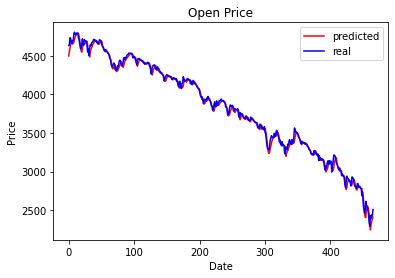

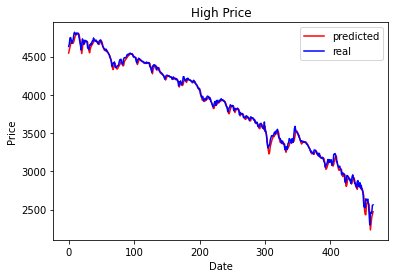

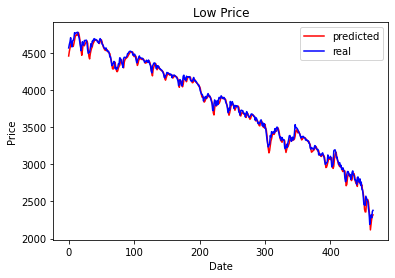

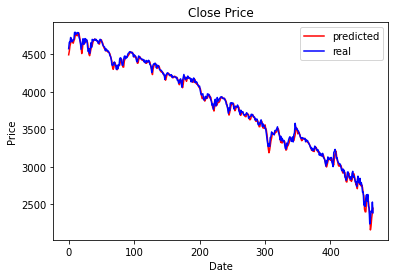

In [57]:
for i in range(columns):
    length = len(zipped_preds[i])
    plt.plot(range(length), zipped_preds[i], color ='r', 
             label ='predicted')

    plt.plot(range(length), zipped_output[i], color ='b', 
             label ='real')

    # naming of x-axis and y-axis
    plt.xlabel('Date')
    plt.ylabel('Price')

    # naming the title of the plot
    plt.title(titles[i])

    plt.legend()
    plt.show()